In [161]:
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

## Extracting Data

In [74]:
filename = 'MNIST_Subset.h5'
with h5py.File(filename, 'r') as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    b_group_key = list(f.keys())[1]
    # Get the data
    data = list(f[a_group_key])
    target = list(f[b_group_key])
dat = []

for i in range(len(data)):
    l = []
    for j in range(28):
        for k in range(28):
            l.append(data[i][j][k])
    dat.append(np.asarray(l))
dat = np.asarray(dat)
target = np.asarray(target)
f = []
for i in range(len(target)):
    if target[i] == 7:
        f.append([[1, 0]])
    else:
        f.append([[0, 1]])
target = np.asarray(f)

## Defining Neural Network 

In [102]:
def sigmoid(s):
    return 1/(1 + np.exp(-s))

def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum()

def sigmoid_derv(s):
    return sigmoid(s) * (1 - sigmoid(s))

def cross_entropy(pred, real):
    n_samples = real.shape[0]
    res = pred - real
    return res/n_samples

# def error(pred, real):
#     n_samples = real.shape[0]
#     logp = - np.log(pred[np.arange(n_samples), real.argmax(axis=0)])
#     loss = np.sum(logp)/n_samples
#     return loss
def error(pred, real):
    n_samples = real.shape[0]
    logp = - np.log(pred[np.arange(n_samples), real.argmax(axis=1)])
    loss = np.sum(logp)/n_samples
    return loss

In [295]:
class neuralnet:
    def __init__(self, x, y, x_valid, y_valid, layers, neurons):
        self.input = x
        self.output = y
        self.count = 0 
        self.loss = 0
        self.xvalid = x_valid
        self.yvalid = y_valid
        self.we = []
        self.bi = []
        self.layers = layers+1
        self.lr = 0.001       # user defined learning rate
        ip_dim = x.shape[1] # input layer size 
        op_dim = 2 # output layer size 2
        w = []
        b = []
        for i in range(len(neurons)+1):
            if i==0:
                w.append(np.random.randn(ip_dim, neurons[i])) # weights
                b.append(np.zeros((1, neurons[i])))           # biases
            elif i==len(neurons):  
                w.append(np.random.randn(neurons[i-1], op_dim))
                b.append(np.zeros((1, op_dim)))
            else:    
                w.append(np.random.randn(neurons[i-1], neurons[i]))
                b.append(np.zeros((1, neurons[i])))
        self.weights = w
        self.biases = b

    
    def feedforward(self):
        a = []
        z = []
        for i in range(self.layers):
            if i == 0:
                z.append(np.dot(self.x, self.weights[i]) + self.biases[i])
                a.append(sigmoid(z[i]))
            elif i == self.layers-1:
                z.append(np.dot(a[i-1], self.weights[i]) + self.biases[i])
                a.append(softmax(z[i]))
            else:    
                z.append(np.dot(a[i-1], self.weights[i]) + self.biases[i])
                a.append(sigmoid(z[i]))
        self.a = a
        self.z = z
                    
    def backprop(self):
        loss = error(self.a[-1], self.y)
        self.loss += loss
#         if (self.a[-1][0][0]>=self.a[-1][0][1] and self.y[0][0]==1) or (self.a[-1][0][1]>self.a[-1][0][0] and self.y[0][1]==1):
#             self.count+=1
        a_delta = []
        z_delta = []
        l = len(self.a)
        
        for i in range(l):
            if i == 0:
                a_delta.append(cross_entropy(self.a[l-i-1], self.y))
            else:
                z_delta.append(np.dot(a_delta[i-1], self.weights[l-i].T))
                a_delta.append(z_delta[i-1] * sigmoid_derv(self.a[l-i-1]))
        
        for i in range(len(self.a) - 1, -1, -1):
            if i == 0:
                self.weights[i] -= self.lr * np.dot(np.reshape(self.x.T,(784,1)), a_delta[l-i-1]) 
                self.biases[i] -= self.lr * np.sum(a_delta[l-i-1], axis=0, keepdims=True)
            else: 
                self.weights[i] -= self.lr * np.dot(self.a[i-1].T, a_delta[l-i-1]) 
                self.biases[i] -= self.lr * np.sum(a_delta[l-i-1], axis=0, keepdims=True)
    
    def train(self): 
        w = []
        valid_ac = []
        train_ac = []
        valid_loss = []
        train_loss = []
        b = []
        for j in range(10):
            self.count = 0 
            self.loss = 0
            for k in range(len(self.xvalid)):
                self.x = self.xvalid[k]
                self.y = self.yvalid[k]
                self.feedforward()
                if (self.a[-1][0][0]>=self.a[-1][0][1] and self.y[0][0]==1) or (self.a[-1][0][1]>self.a[-1][0][0] and self.y[0][1]==1):
                    self.count+=1
                loss = error(self.a[-1], self.y)
                self.loss += loss    
            valid_ac.append(self.count/len(self.xvalid))  
            valid_loss.append(self.loss/len(self.xvalid))
            self.count = 0 
            self.loss = 0
            for i in range(len(self.input)):
                self.x = self.input[i]
                self.y = self.output[i]
                self.feedforward()
                if (self.a[-1][0][0]>=self.a[-1][0][1] and self.y[0][0]==1) or (self.a[-1][0][1]>self.a[-1][0][0] and self.y[0][1]==1):
                    self.count+=1
                loss = error(self.a[-1], self.y)
                self.loss += loss
            print('accuracy after epoch ', j ," ",self.count/len(self.input))
            train_ac.append(self.count/len(self.input))
            train_loss.append(self.loss/len(self.input))
            for i in range(len(self.input)):
                self.x = self.input[i]
                self.y = self.output[i]
                self.feedforward()
                self.backprop()    
        return valid_ac,train_ac,valid_loss,train_loss
        
    def accuracy(self, x, y):
        ac = []
        acc = 0
        for i in range(len(x)):
            self.x = x[i]
            self.y = y[i]
            self.feedforward()
            if (self.a[-1][0][0]>=self.a[-1][0][1] and self.y[0][0]==1) or (self.a[-1][0][1]>self.a[-1][0][0] and self.y[0][1]==1):
                acc+=1
        return acc
    
    def closs(self, x, y):
        l=0
        for i in range(len(x)):
            self.x = x[i]
            self.y = y[i]
            self.feedforward()
            loss = error(self.a[-1], self.y)
            l += loss
        return l

In [226]:
X_train, X_test, y_train, y_test = train_test_split(dat, target, test_size=0.10)
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

In [296]:
nn = neuralnet(x_train, y_train,x_valid,y_valid, 3, [100, 50, 50])
[valid_ac,train_ac, valid_loss,train_loss] = nn.train()

c:\users\siddha~1\docume~1\courses\monsoo~1\ml2019~1\hw3\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


accuracy after epoch  0   0.4266581047610311
accuracy after epoch  1   0.948078157967159
accuracy after epoch  2   0.9573433629942207
accuracy after epoch  3   0.9522979543161177
accuracy after epoch  4   0.9643152004403266
accuracy after epoch  5   0.9687184661957619
accuracy after epoch  6   0.9690854050087148
accuracy after epoch  7   0.9704614255572883
accuracy after epoch  8   0.9702779561508118
accuracy after epoch  9   0.9725713237317677


Text(0, 0.5, 'loss')

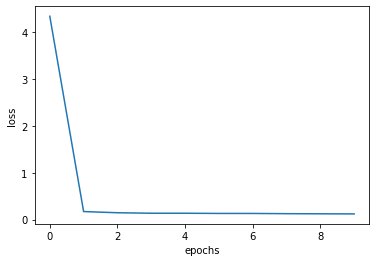

In [284]:
# ac_valid = nn.accuracy(x_valid, y_valid)
# ac_train = nn.accuracy(x_train, y_train)
x = []
for i in range(10):
    x.append(i)
# figure
plt.plot(x, train_loss)
plt.xlabel('epochs')
plt.ylabel('loss')

In [286]:
for i in range(10):
    print("loss for epoch ",i," ", train_loss[i])

loss for epoch  0   4.343575062122489
loss for epoch  1   0.1722105449354259
loss for epoch  2   0.1471889534901068
loss for epoch  3   0.13643469777021686
loss for epoch  4   0.1364634457474806
loss for epoch  5   0.132423139071859
loss for epoch  6   0.13208689874179652
loss for epoch  7   0.12717914305915753
loss for epoch  8   0.12455246344901189
loss for epoch  9   0.12203255458789872


In [303]:
print("accuracy ",nn.accuracy(X_test, y_test)/len(X_test))
print("loss ",nn.closs(X_test, y_test)/len(X_test))

c:\users\siddha~1\docume~1\courses\monsoo~1\ml2019~1\hw3\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


accuracy  0.9642356241234221
loss  0.09940780557905077


## t-SNE Plots

In [116]:
from sklearn.manifold import TSNE

In [117]:
weights = nn.weights[-1]

In [118]:
weights.shape

(50, 2)

In [120]:
tsne = TSNE(n_components=2, random_state=42, verbose=1)
transformed_weights = tsne.fit_transform(weights)

[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.207s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 1.153572
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.074017
[t-SNE] KL divergence after 1000 iterations: 0.604862


In [127]:
# import matplotlib.pyplot as plt
# plt.show(transformed_weights)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Comparing with sklearn's MLP Classifier

In [305]:
filename = 'MNIST_Subset.h5'
with h5py.File(filename, 'r') as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
    b_group_key = list(f.keys())[1]
    # Get the data
    data = list(f[a_group_key])
    target = list(f[b_group_key])
dat = []
for i in range(len(data)):
    l = []
    for j in range(28):
        for k in range(28):
            l.append(data[i][j][k])
    dat.append(np.asarray(l))
dat = np.asarray(dat)
target = np.asarray(target)
f = []
for i in range(len(target)):
    if target[i] == 7:
        f.append([1, 0])
    else:
        f.append([0, 1])
tg = np.asarray(f)

X_train, X_test, y_train, y_test = train_test_split(dat, tg, test_size=0.10, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

Keys: <KeysViewHDF5 ['X', 'Y']>


In [306]:
clf = MLPClassifier(solver='sgd', alpha=1e-5,
                    hidden_layer_sizes=(100, 50, 50), random_state=1)

In [307]:
clf.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50, 50), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [311]:
print(clf.score(x_train,y_train))
print(clf.score(x_valid, y_valid))
print(clf.score(X_test, y_test))

0.9999082652967618
0.9797297297297297
0.9803646563814866


In [313]:
from sklearn import metrics

In [314]:
metrics.log_loss(clf.predict(x_train), y_train)

0.0031684044027998873

In [315]:
metrics.log_loss(clf.predict(x_valid),y_valid)

0.6642072383636679

In [316]:
metrics.log_loss(clf.predict(X_test),y_test)

0.6297392610572785